# Load MNIST handwritten digits dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
import numpy as np
# Plot train and test loss
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

def normalize_image(image, label):
    return tf.cast(image, tf.float32) / 255., label

def autoencoder_map_fn(x, y):
    return (x, x)

mnist_train = mnist_train.cache().shuffle(buffer_size=10_000).batch(128).map(normalize_image)
mnist_test = mnist_test.cache().batch(128).map(normalize_image)

2024-01-23 23:26:19.344054: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-01-23 23:26:19.344072: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-01-23 23:26:19.344076: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-01-23 23:26:19.344101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-23 23:26:19.344116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# for x, y in mnist_train.take(1):
#     print(x.shape, y.shape)
#     break

x = tf.random.normal((1, 28, 28, 1))

# Define our autoencoder model

In [3]:
from functools import reduce
from typing import Iterable
from keras import layers as L
from keras import Model


def encoder(input_dim: Iterable[int], latent_dim: int = 8, noise_std=0.05, dropout=0.2) -> Model:
    inputs = L.Input(shape=input_dim)
    x = L.Flatten()(inputs)
    x = L.GaussianNoise(noise_std)(x)
    x = L.BatchNormalization()(x)

    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim * 16, activation='relu')(x)
    x = L.LayerNormalization()(x)
    
    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim, activation='linear')(x)
    x = L.LayerNormalization()(x)
    
    model = Model(inputs=inputs, outputs=x, name='encoder')
    return model


def decoder(latent_dim: int = 8, output_dim: Iterable[int] = (28, 28, 1), dropout=0.2) -> Model:
    output_dim_size: int = reduce(lambda x, y: x * y, output_dim)
    inputs = L.Input(shape=(latent_dim,))
    
    x = L.Dense(latent_dim * 16, activation='relu')(inputs)
    x = L.Dropout(dropout)(x)
    x = L.LayerNormalization()(x)

    x = L.Dense(output_dim_size, activation='sigmoid')(x)
    x = L.Reshape(output_dim)(x)
    
    model = Model(inputs=inputs, outputs=x, name='decoder')
    return model


# encoder(input_dim=(28, 28, 1))(x[None, ...]).shape

In [4]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from functools import reduce
from typing import Iterable

def encoder(input_dim: Iterable[int], latent_dim: int = 8, noise_std=0.05, dropout=0.2) -> Model:
    # Input layer
    inputs = L.Input(shape=input_dim)
    x = L.GaussianNoise(noise_std)(inputs)
    
    # Convolutional layers
    x = L.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = L.MaxPooling2D((2, 2), padding='same')(x)
    x = L.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = L.MaxPooling2D((2, 2), padding='same')(x)
    
    # Flatten layer to prepare for dense layer
    x = L.Flatten()(x)
    
    # Noise and normalization
    x = L.BatchNormalization()(x)

    # Dense layers
    x = L.Dropout(dropout)(x)
    x = L.Dense(latent_dim * 16, activation='relu')(x)
    x = L.LayerNormalization()(x)
    
    # Output layer
    x = L.Dense(latent_dim, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=x, name='encoder')
    return model

def decoder(latent_dim: int = 8, output_dim: Iterable[int] = (28, 28, 1), dropout=0.2) -> Model:
    # Calculate the size of the output before reshaping
    output_dim_size: int = reduce(lambda x, y: x * y, output_dim)
    w, h, c = output_dim
    
    # Input layer
    inputs = L.Input(shape=(latent_dim,))
    
    # Dense layer to prepare for convolutional layers
    x = L.Dense(latent_dim * 16, activation='relu')(inputs)
    x = L.Dropout(dropout)(x)
    x = L.LayerNormalization()(x)
    
    # Reshape to prepare for convolutional layers
    x = L.Reshape((4, 4, latent_dim))(x)
    
    # Convolutional layers
    x = L.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = L.UpSampling2D((2, 2))(x)
    x = L.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    
    # Output layer
    x = L.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=x[..., :w, :h, :c], name='decoder')
    return model


z = encoder(input_dim=(28, 28, 1))(x)
_x = decoder(latent_dim=8, output_dim=(28, 28, 1))(z)

z.shape, _x.shape

(TensorShape([1, 8]), TensorShape([1, 28, 28, 1]))

In [5]:
latent_dim: int = 10
image_dim: Iterable[int] = (28, 28, 1)

e = encoder(input_dim=image_dim, latent_dim=latent_dim)
d = decoder(latent_dim=latent_dim, output_dim=image_dim)

z = e(x)
x_hat = d(z)

print("Encoder: {} -> {}".format(x.shape, z.shape))
print("Decoder: {} -> {}".format(z.shape, x_hat.shape))

Encoder: (1, 28, 28, 1) -> (1, 10)
Decoder: (1, 10) -> (1, 28, 28, 1)


# Train our autoencoder model

In [6]:
inputs = L.Input(shape=image_dim)
z = e(inputs)
outputs = d(z)

autoencoder = Model(inputs=inputs, outputs=outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 10)                135610    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         8465      
                                                                 
Total params: 144075 (562.79 KB)
Trainable params: 142507 (556.67 KB)
Non-trainable params: 1568 (6.12 KB)
_________________________________________________________________


In [7]:
history = autoencoder.fit(
    mnist_train.map(autoencoder_map_fn),  # (x, x) because we want to reconstruct the same image
    epochs=10,
    validation_data=mnist_test.map(autoencoder_map_fn),
)

Epoch 1/10


2024-01-23 23:26:22.369321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 15s 22ms/step - loss: 0.1311 - val_loss: 0.0999
Epoch 2/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0848 - val_loss: 0.0631
Epoch 3/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0665 - val_loss: 0.0582
Epoch 4/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0639 - val_loss: 0.0567
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0623 - val_loss: 0.0546
Epoch 6/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0614 - val_loss: 0.0548
Epoch 7/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0607 - val_loss: 0.0534
Epoch 8/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0601 - val_loss: 0.0531
Epoch 9/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0597 - val_loss: 0.0527
Epoch 10/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0591 - val_loss: 0.05

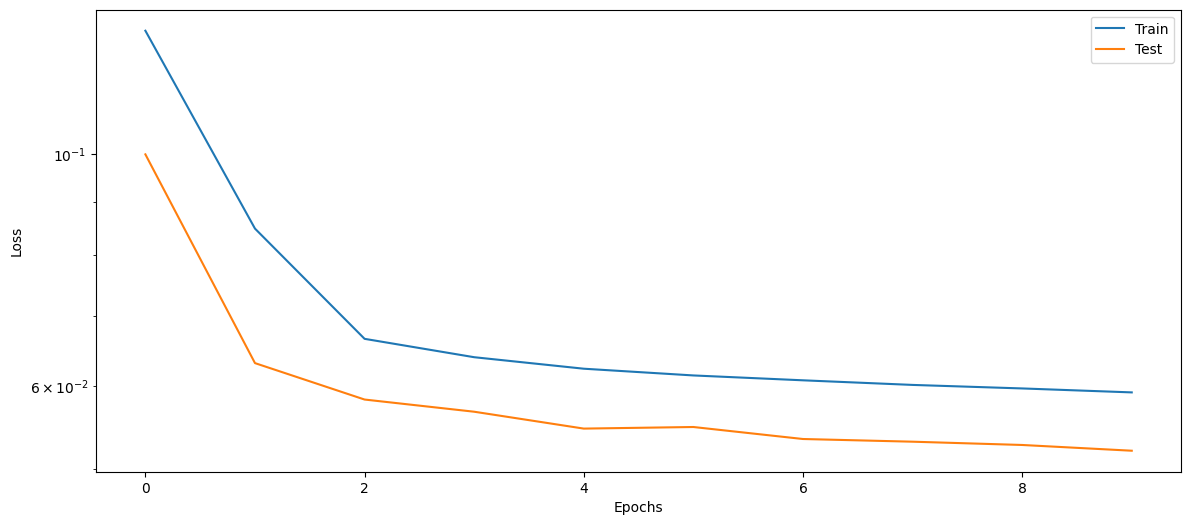

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')

# log scale
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

# Look at the Latent Space Representations

In [9]:
z_train = e.predict(mnist_train)

z_train.shape

469/469 [==============================] - 1s 2ms/step


(60000, 10)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

y_train = np.concatenate([y for x, y in mnist_train], axis=0)

classifier = QuadraticDiscriminantAnalysis().fit(z_train, y_train)

In [11]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, classifier.predict_proba(z_train), multi_class='ovr')

0.5259974441409313

# 

In [12]:
for x, y in mnist_train.take(1):
    z = e.predict(x)
    x_hat = d.predict(z)
    break

4/4 [==============================] - 0s 5ms/step


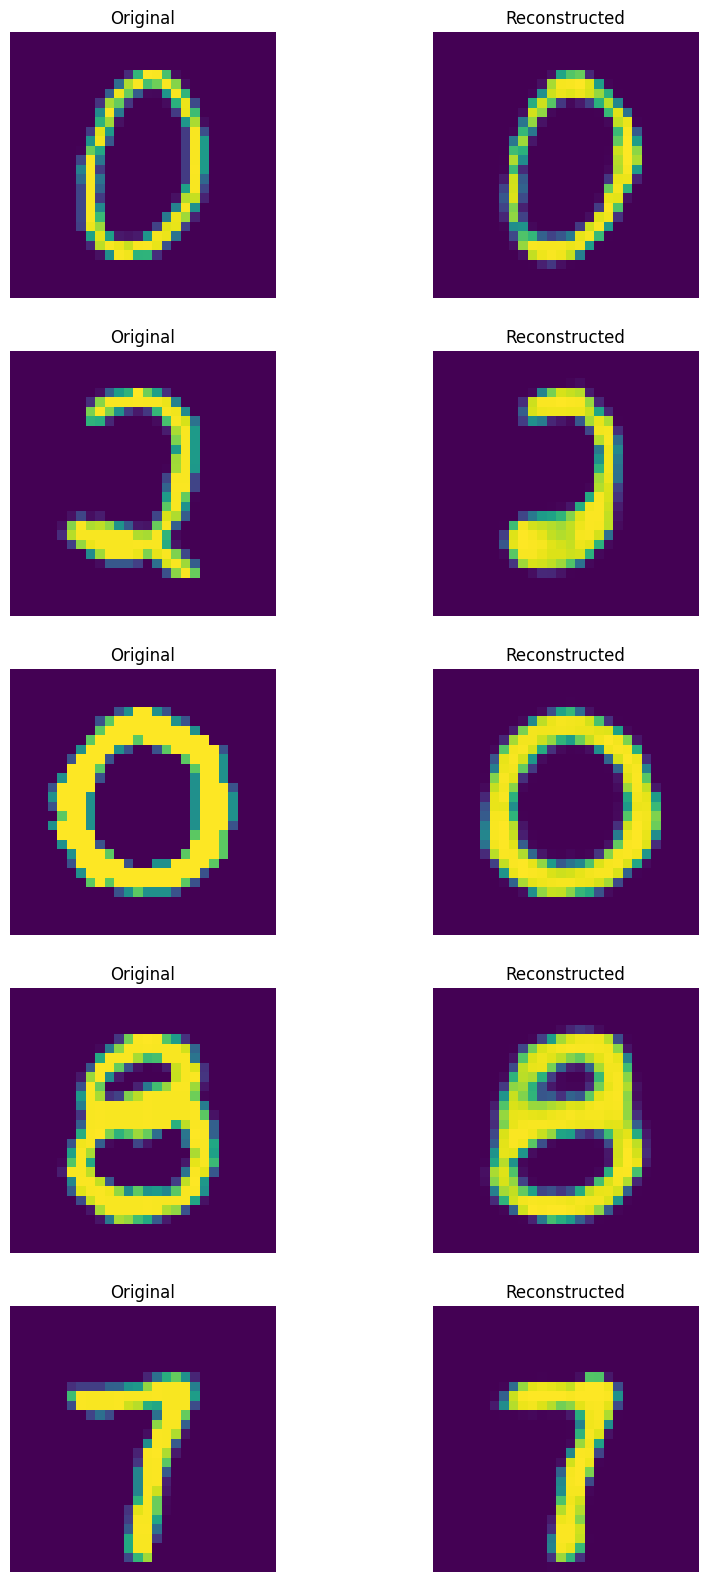

In [13]:
n_images: int = 5

# Show them side by side
fig, ax = plt.subplots(n_images, 2, figsize=(10, 20))

for i in range(n_images):
    label = y[i].numpy()
    ax[i, 0].imshow(x[i, ..., 0], cmap='viridis')
    ax[i, 1].imshow(x_hat[i, ..., 0], cmap='viridis')

    ax[i, 0].set_title('Original')
    ax[i, 1].set_title('Reconstructed')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

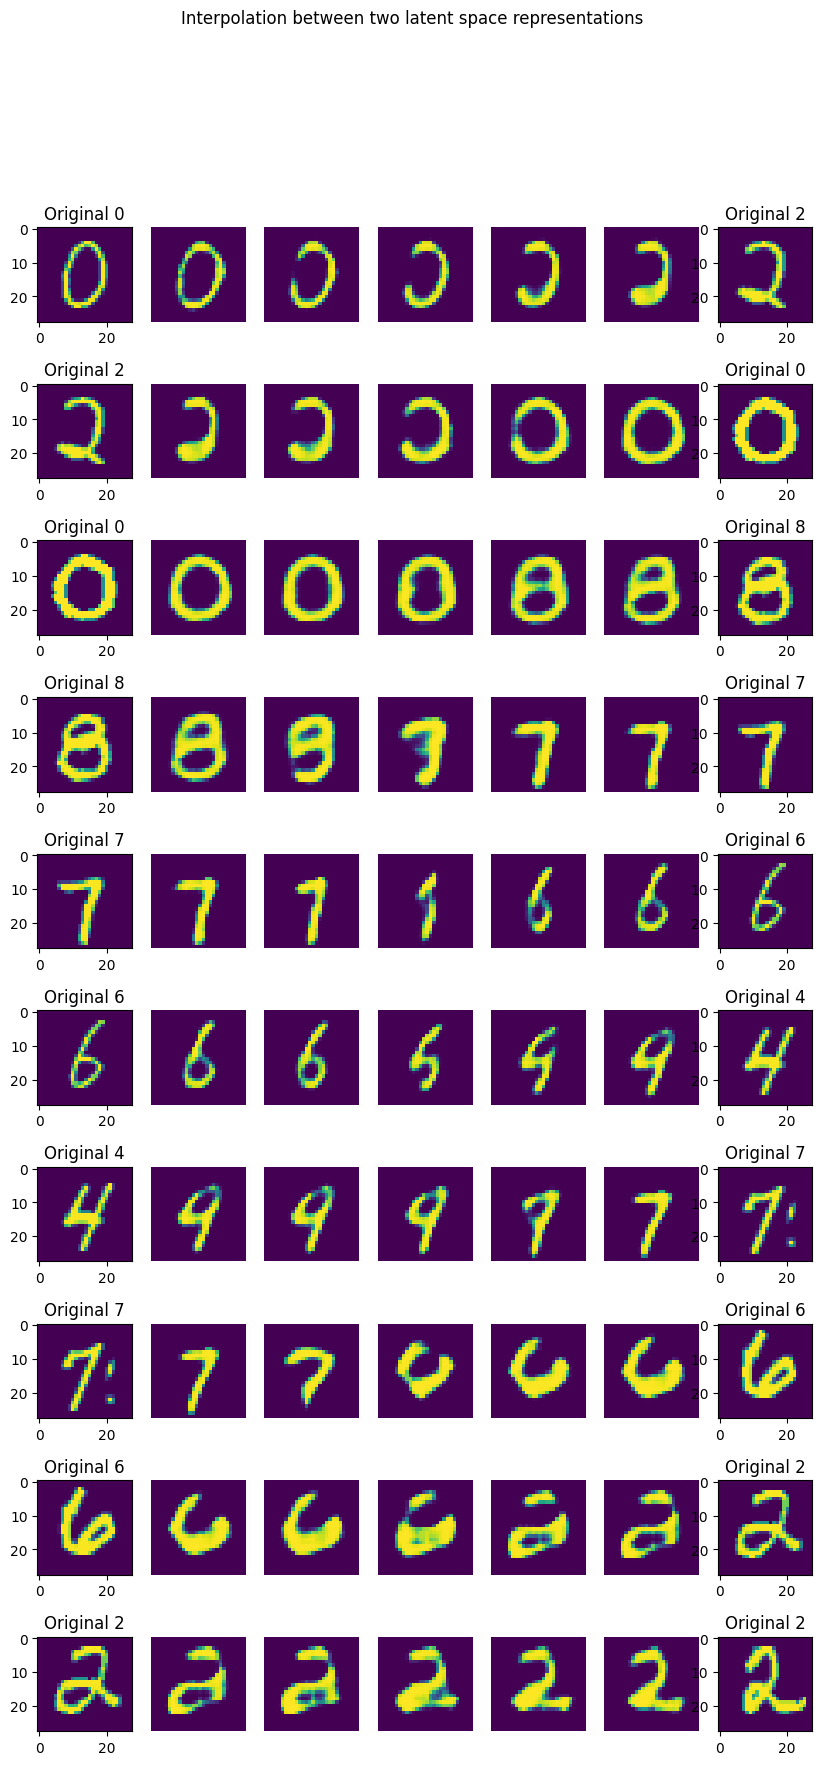

In [14]:
n_steps: int = 5
n_images: int = 10

fig, axs = plt.subplots(n_images, n_steps + 2, figsize=(10, 20))

for idx in range(n_images):
    a_original = x[idx]
    a_label = y[idx].numpy()
    b_original = x[idx + 1]
    b_label = y[idx + 1].numpy()
    a = z[idx]
    b = z[idx + 1]
    z_hat = a + (b - a) * np.linspace(0, 1, n_steps)[:, None]
    x_hat = d.predict(z_hat, verbose=0)
    
    axs[idx, 0].imshow(a_original[..., 0], cmap='viridis')
    axs[idx, 0].set_title('Original {}'.format(a_label))

    for i in range(n_steps):
        axs[idx, i + 1].imshow(x_hat[i, ..., 0], cmap='viridis')
        axs[idx, i + 1].axis('off')
        
    axs[idx, -1].imshow(b_original[..., 0], cmap='viridis')
    axs[idx, -1].set_title('Original {}'.format(b_label))

_ = fig.suptitle('Interpolation between two latent space representations')

In [15]:
# Cluster the latent space representations

1/1 [==============================] - 0s 8ms/step


Text(0.5, 1.0, 'Mean 2')

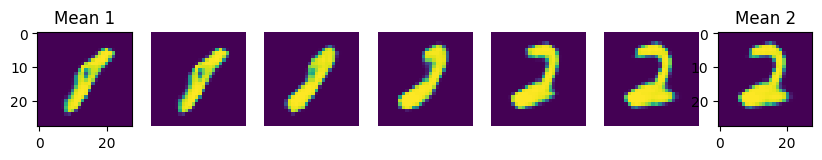

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10).fit(z_train)

# And morph from mean 1 to mean 2
z_mean_1 = kmeans.cluster_centers_[0]
z_mean_2 = kmeans.cluster_centers_[1]
z_hat = z_mean_1 + (z_mean_2 - z_mean_1) * np.linspace(0, 1, n_steps)[:, None]
x_hat = d.predict(z_hat, verbose=0)

fig, axs = plt.subplots(1, n_steps + 2, figsize=(10, 2))

axs[0].imshow(d.predict(z_mean_1[None, ...])[0, ..., 0], cmap='viridis')
axs[0].set_title('Mean 1')

for i in range(n_steps):
    axs[i + 1].imshow(x_hat[i, ..., 0], cmap='viridis')
    axs[i + 1].axis('off')

axs[-1].imshow(d.predict(z_mean_2[None, ...])[0, ..., 0], cmap='viridis')
axs[-1].set_title('Mean 2')